In [41]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
import zarr
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import gym_pusht


def make_env(differential_action=False, render_mode='rgb_array', pixels_based_success=False):
    # Adjust the env_id if you are using a specific repo 
    # (e.g., 'gym_pusht/PushT-v0' or a local import like PushTImageEnv)
    ENV_ID = "gym_pusht/PushT-v0"

    try:
        # We use render_mode='human' to see the replay live, 
        # or 'rgb_array' if you want to save frames.
        env = gym.make(ENV_ID, render_mode=render_mode, differential_action=differential_action, observation_width=64, observation_height=64, pixels_based_success=pixels_based_success)
        # env = gym.make(ENV_ID, render_mode="rgb_array")
        
        print(f"Successfully created environment: {ENV_ID}")
        
        # Reset to check if it works
        obs, info = env.reset()
        
    except Exception as e:
        print(f"Error creating environment: {e}")
        print("Ensure gym-pusht is installed or adjust the ENV_ID.")
        # print out the environments that gym is aware of
        print("Available environments:", gym.envs.registry.keys())
        env=None
    return env


In [43]:
# import time
# env = make_env(differential_action=True)
# for _ in range(10):
#     env.step(np.array([100, 100.0]))
#     env.render()
#     time.sleep(0.1)

In [44]:
def inspect_zarr_file(zarr_path):
    """
    Opens the Zarr file and prints the tree structure 
    to help identify the keys for states, actions, and images.
    """
    try:
        root = zarr.open(zarr_path, mode='r')
        print(f"Opened Zarr file at: {zarr_path}")
        print("-" * 20)
        print(root.tree())
        return root
    except Exception as e:
        print(f"Failed to load Zarr file. Download from https://diffusion-policy.cs.columbia.edu/data/training/ : {e}.")

        return None

# Replace with your actual path
ZARR_PATH = "/home/j/workspace/gym-pusht/demonstrations/pusht/pusht_cchi_v7_replay.zarr"
root = inspect_zarr_file(ZARR_PATH)

Opened Zarr file at: /home/j/workspace/gym-pusht/demonstrations/pusht/pusht_cchi_v7_replay.zarr
--------------------
/
 ├── data
 │   ├── action (25650, 2) float32
 │   ├── img (25650, 96, 96, 3) float32
 │   ├── keypoint (25650, 9, 2) float32
 │   ├── n_contacts (25650, 1) float32
 │   └── state (25650, 5) float32
 └── meta
     └── episode_ends (206,) int64


In [45]:
def find_offset(zarr_path, ep_idx):
    root = zarr.open(zarr_path, mode='r')
    
    # Grab the first frame
    state_0 = root['data/state'][ep_idx]    # [agent_x, agent_y, block_x, block_y, angle]
    kps_0 = root['data/keypoint'][ep_idx]   # [k1, k2, ..., k9]
    
    # Physics position of the block from state
    physics_pos = state_0[2:4]
    
    # Visual center is usually roughly the mean of all keypoints
    # OR sometimes specifically keypoint index 3 or 4 depending on the specific PushT version
    visual_pos = np.mean(kps_0, axis=0) 
    
    offset = physics_pos - visual_pos
    
    print(f"Physics Position: {physics_pos}")
    print(f"Visual Centroid:  {visual_pos}")
    print(f"Calculated Offset: {offset}")
    return offset

offset = find_offset(ZARR_PATH, 0)

Physics Position: [222.99382 381.59903]
Visual Centroid:  [217.55998 341.68152]
Calculated Offset: [ 5.433838 39.91751 ]


Loaded 206 episodes.
Pusht force sparse reward:  False  display_cross:  False
Successfully created environment: gym_pusht/PushT-v0
Pusht force sparse reward:  False  display_cross:  False
Successfully created environment: gym_pusht/PushT-v0
diff position +89.80
Total steps taken: 394, demo length: 161


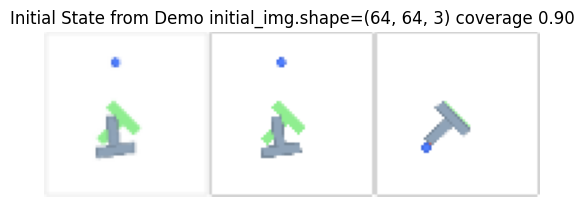

Episode replay complete. info['coverage']=np.float64(0.9029126213592233) coverage=np.float64(0.9029126213592233) vs pixel coverage 0.90. Total reward: 126.95. info['is_success']=np.False_


In [ ]:
import collections

def load_pusht_demos(zarr_path):
    """
    Loads actions and states from Zarr and splits them into episodes
    based on 'meta/episode_ends'.
    """
    root = zarr.open(zarr_path, mode='r')
    
    # Load raw flattened arrays
    all_actions = root['data/action'][:]
    all_states = root['data/state'][:]
    episode_ends = root['meta/episode_ends'][:]
    
    episodes = []
    start_idx = 0
    
    for end_idx in episode_ends:
        # Slice the data for this specific episode
        episode_data = {
            'action': all_actions[start_idx:end_idx],
            'state': all_states[start_idx:end_idx],
            # We don't strictly need images for replay (we can render live), 
            # but you can load them here if needed:
            'img': root['data/img'][start_idx:end_idx],
            'keypoint': root['data/keypoint'][start_idx:end_idx]
        }
        episodes.append(episode_data)
        start_idx = end_idx
        
    print(f"Loaded {len(episodes)} episodes.")
    return episodes

import time
def replay_demo(env, episode_data, fps=60, differential_action=False):
    """
    Resets the environment to the demo's initial state and replays actions.
    """
    
    # 2. Force the environment state to match the demo's first frame.
    #    The state usually contains [agent_x, agent_y, block_x, block_y, block_theta].
    #    Without this, the block will be in a random spot and the actions won't make sense.
    initial_state = episode_data['state'][0]

    # 1. Reset environment for the wrappers and then for the initial state
    env.reset()
    obs, info = env.unwrapped.reset(options={"reset_to_state": initial_state})
    for _ in range(100): # takes time to arrive at the target state
        env.unwrapped._set_state(initial_state)
    env_img = env.render()
    # print(f"{initial_state=}")
    # show the initial image in episode_data
    initial_img = episode_data['img'][0].astype(np.uint8)
    final_img = episode_data['img'][-1].astype(np.uint8)

    print(f'diff position {np.linalg.norm(obs - initial_state):+1.2f}')

    # 3. Execute actions
    actions = episode_data['action']

    total_reward = 0
    
    if differential_action:
        # The difference between the consecutive agent positions is our differential action
        states = episode_data['state']; state_idx = 1;nsteps=0
        target_state = states[state_idx]; target_state_threshold = 1.0
        def close_enough(a, b, thresh):
            return np.linalg.norm(a - b) < thresh
        while True:
            action = target_state[0:2] - env.unwrapped.agent.position
            obs, reward, terminated, truncated, info = env.step(action); nsteps+=1
            total_reward += reward
            env.render()

            if close_enough(env.unwrapped.agent.position, target_state[0:2], target_state_threshold):
                state_idx += 1
                if state_idx < len(states):
                    target_state = states[state_idx]
                else:
                    break
        
        print(f"Total steps taken: {nsteps}, demo length: {len(states)}")
        # repeat the last action
        obs, reward, terminated, truncated, info = env.step(action)
    else:
        for action in actions:
            # Step the environment
            obs, reward, terminated, truncated, info = env.step(action)
            total_reward += reward
            final_env_img = env.render()
            
            # Render is handled automatically by render_mode='human' in env creation
            # If you need to slow it down to be viewable:
            # plt.pause(1/fps) 
            # time.sleep(1/fps)

        # add one more action that's the same as the last action, since these demonstrations seem to end a step early
        obs, reward, terminated, truncated, info = env.step(actions[-1])
        total_reward += reward
        # for _ in range(2):
        #     obs, reward, terminated, truncated, info = env.step(actions[-1])

    final_env_img = env.render()
    toshow = np.hstack([initial_img, env_img, final_env_img])
    plt.imshow(toshow)
    plt.axis('off')
    plt.title(f"Initial State from Demo {initial_img.shape=} coverage {info['coverage']:1.2f}")
    plt.show(block=False)
    pixel_coverage = env.unwrapped._get_pixel_coverage()
    coverage = env.unwrapped._get_coverage()
    print(f"Episode replay complete. {info['coverage']=} {coverage=} vs pixel coverage {pixel_coverage:1.2f}. Total reward: {total_reward:1.2f}. {info['is_success']=}")

    return info['coverage'], pixel_coverage

# --- Usage ---
import copy, collections

differential_action = True

# 1. Load the episodes
demos = load_pusht_demos(ZARR_PATH)


env = make_env(differential_action=differential_action, pixels_based_success=True)
# resize the images if the env observation size is different from the demo image size
if env.unwrapped.observation_width != demos[0]['img'].shape[1] or env.unwrapped.observation_height != demos[0]['img'].shape[2]:
    for ep in demos:
        img = ep['img']
        if img.shape[1] != 64 or img.shape[2] != 64:
            from skimage.transform import resize
            resized_imgs = []
            for im in img:
                im_resized = resize(im, (64, 64), preserve_range=True).astype(np.uint8)
                resized_imgs.append(im_resized)
            ep['img'] = np.array(resized_imgs)

coverages = collections.defaultdict(list)
pixel_coverages = collections.defaultdict(list)
# # 2. Replay the first 3 episodes
for y_offset in [0]: #range(40,50,1):
    env = make_env(differential_action=differential_action, pixels_based_success=True)
    coverage = []
    pixel_coverage = []
    for i in range(206):
    # for i in [0]:
        # print(f"Replaying Episode {i}...")
        offset = [0, 0] # find_offset(ZARR_PATH, ep_idx=i)
        cov, pix_cov = replay_demo(env, copy.deepcopy(demos[i]), fps=120, differential_action=differential_action)
        coverage.append(cov)
        pixel_coverage.append(pix_cov)
    coverages[y_offset] = coverage
    pixel_coverages[y_offset] = pixel_coverage

# # Close env when done
# time.sleep(1)
# env.close()

In [47]:
if TUNE_TOLERANCE:=False:
        GOAL_COLOR = np.array([144, 238, 144])
        for TOLERANCE in [5.0, 10.0, 20.0, 30.0, 40.]:
                a = env.unwrapped

                # Calculate max possible green pixels
                # Render with only goal visible
                # Note: We use visualization_width/height for high res coverage, or observation_width?
                # User request: "care about the number of green pixels showing at the target rendering resoultion"
                # Assuming "target rendering resolution" means "observation resolution" unless visualize is used.
                # But coverage is used for reward, which happens every step.
                # Usually observations are small (96x96).
                pixels = a._render(visualize=False, draw_agent=False, draw_block=False)
                
                # Count green pixels
                # Using Euclidean distance in RGB space
                diff = np.linalg.norm(pixels.astype(float) - GOAL_COLOR, axis=-1)
                a._max_green_pixels = np.sum(diff < TOLERANCE)
                
                if a._max_green_pixels == 0:
                        # Should not happen unless goal is off screen or invisible
                        a._max_green_pixels = 1.0 # Avoid division by zero
                                
                # Calculate current green pixels
                pixels = a._render(visualize=False, draw_agent=True, draw_block=True)
                diff = np.linalg.norm(pixels.astype(float) - GOAL_COLOR, axis=-1)
                current_green_pixels = np.sum(diff < TOLERANCE)

                # Coverage is the proportion of goal pixels that are NOT visible (covered by block)
                # Wait, "number of green pixels showing".
                # If block covers goal, fewer green pixels show.
                # So "coverage" (success metric) is usually "how much of goal is covered".
                # If 100% covered, 0 green pixels show.
                # So coverage = 1.0 - (current / max)

                coverage = 1.0 - (current_green_pixels / a._max_green_pixels)
                print(f"Current green pixels: {current_green_pixels}, Max green pixels: {a._max_green_pixels}, Coverage: {coverage:1.2f}")

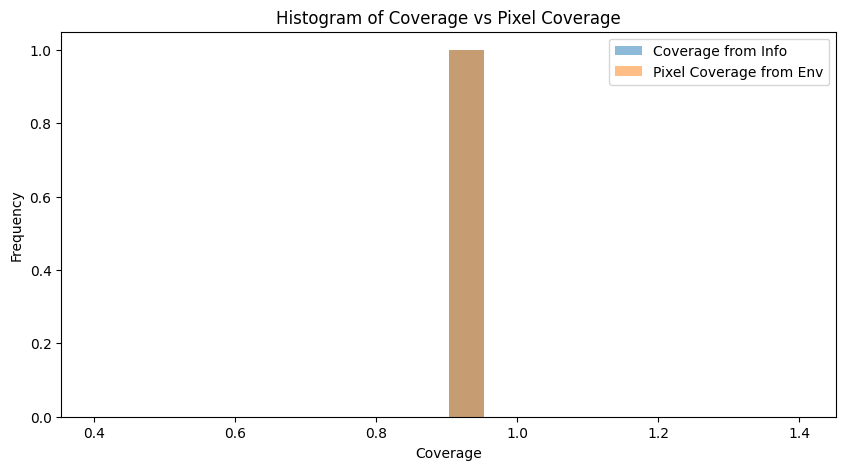

In [48]:
# histogram of coverage vs pixel coverage
c = coverages[0]
pc = pixel_coverages[0]
plt.figure(figsize=(10,5))
plt.hist(c, bins=20, alpha=0.5, label='Coverage from Info')
plt.hist(pc, bins=20, alpha=0.5, label='Pixel Coverage from Env')
plt.xlabel('Coverage')
plt.ylabel('Frequency')
plt.title('Histogram of Coverage vs Pixel Coverage')
plt.legend()
plt.show()

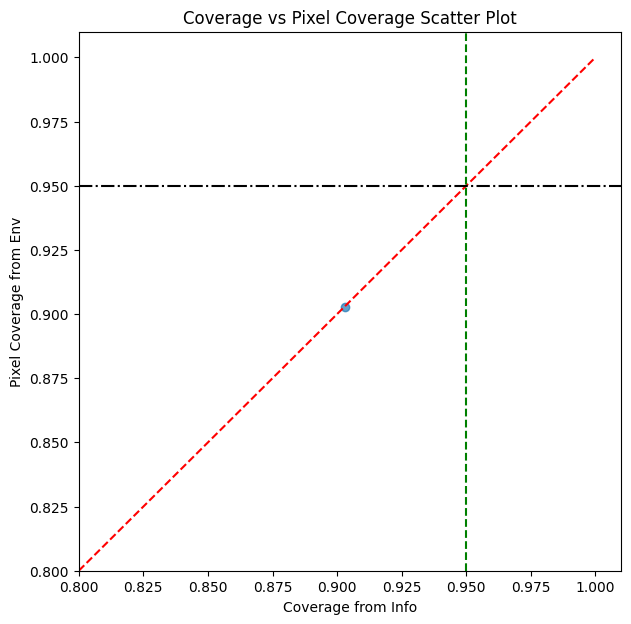

In [49]:
# plot each point coverage vs pixel coverage x,y scatter
plt.figure(figsize=(7,7))
plt.scatter(c, pc, alpha=0.7)
plt.xlabel('Coverage from Info')
plt.ylabel('Pixel Coverage from Env')
plt.title('Coverage vs Pixel Coverage Scatter Plot')

# set the x and y limits to [0,1]
plt.xlim(0.8, 1.01)
plt.ylim(0.8, 1.01)

# plot a y=x line
plt.plot([0.8, 1], [0.8, 1], color='red', linestyle='--')

# vertical line at the environment success threshold
plt.axvline(x=env.unwrapped.success_threshold, color='green', linestyle='--', label='Success Threshold')

# horizontal line at the environment success threshold
plt.axhline(y=env.unwrapped.success_threshold, color='black', linestyle='-.', label='Success Threshold')

plt.show()

In [50]:
# percentage above the success threshold
success_count = sum(1 for cov in c if cov >= env.unwrapped.success_threshold)
total_count = len(c)
success_percentage = (success_count / total_count) * 100
print(f"Success Percentage: {success_percentage:1.2f}% ({success_count}/{total_count})")

# percentage above the success threshold for pixel coverage
success_count_pc = sum(1 for cov in pc if cov >= env.unwrapped.success_threshold)
total_count_pc = len(pc)
success_percentage_pc = (success_count_pc / total_count_pc) * 100
print(f"Pixel Coverage Success Percentage: {success_percentage_pc:1.2f}% ({success_count_pc}/{total_count_pc})")

Success Percentage: 0.00% (0/1)
Pixel Coverage Success Percentage: 0.00% (0/1)


In [51]:
np.mean(coverages[0])

np.float64(0.9029126213592233)

### For the original action space
Mean with 0 extra steps: 0.89939

Mean with 1 extra steps: 0.91195

Mean with 2 extra steps: 0.90637

so these demonstrations are likely terminated a step too early. 

### For the differential action space
Mean with 1 extra steps: 0.84154

In [52]:
env = make_env()
# reset to 0s state
env.unwrapped.reset(options={"reset_to_state": np.zeros(5)})    

Pusht force sparse reward:  False  display_cross:  False
Successfully created environment: gym_pusht/PushT-v0


(array([0., 0., 0., 0., 0.]),
 {'pos_agent': array([0., 0.]),
  'vel_agent': array([0., 0.]),
  'block_pose': array([0., 0., 0.]),
  'goal_pose': array([256.        , 256.        ,   0.78539816]),
  'n_contacts': 1,
  'is_success': False,
  'coverage': 0.0})